# Land Use Optimization

- There is a set of urban blocks in a relatively small area. 
- The task is to to determine the optimal layout of functional zones. 
- Also it is necessary to identify the possible optimal composition of services for this area.

## Optimizing land uses

Load blocks spatial data and visualize it.

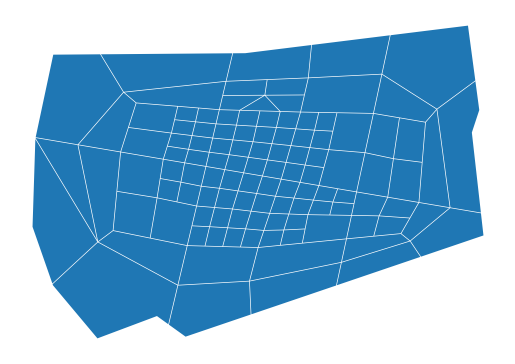

In [1]:
import geopandas as gpd

ETRS89_CODE = 'epsg:25832'

blocks_gdf = gpd.read_file('../blocks.geojson')[['geometry']]
blocks_gdf.geometry = blocks_gdf.to_crs(ETRS89_CODE).buffer(-0.5)
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

Initializing `LandUseOptimizer` instance. After initializing the loaded blocks will also be cut to fit possible aspect ratios. 

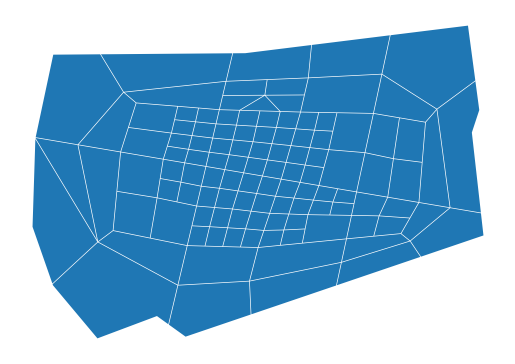

In [2]:
from blocksnet.preprocessing import LandUseOptimizer

luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

Determine desired **Land Use** shares. The optimizer will try to fit these shares using MSE.

In [3]:
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.3,
  LandUse.BUSINESS: 0.2,
  LandUse.RECREATION: 0.2,
  LandUse.SPECIAL: 0.05,
  LandUse.INDUSTRIAL: 0.05,
  LandUse.AGRICULTURE: 0.1,
  LandUse.TRANSPORT: 0.1
}

Run `LandUseOptimizer` instance calculation method `run()`. It will return the following result:
- `best_X` - best variables found in the simulated annealing process.
- `best_value` - best fit value (the smaller it is, the closer optimization was to the desired shares).
- `Xs` - list of X during all the iterations.
- `values` - list of fit values during all the iterations.

The optimizer will try to fit desired shares according to rules:
- Some land uses can't be adjacent to others (like residential and industrial).
- Some land uses have max ratio possible. For example, residential blocks will vary from 1:1 to 1:3.

In [4]:
best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.9999, max_iter=10)

Value : 0.753: 100%|██████████| 10/10 [00:00<00:00, 121.83it/s] 


After the method found some result, we can visualize the flow of fit value to see how it changed.

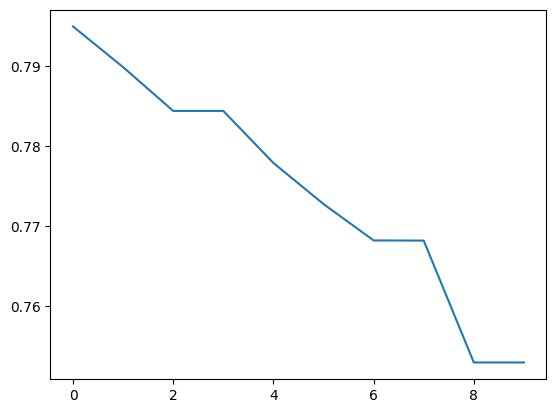

In [5]:
import matplotlib.pyplot as plt

plt.plot(values)

As we can see, it successfully found some kind of value close to `0.0`. Otherwise we could adjust rate, temperature, or iterations of the optimizer.

Let's see how proportions of desired Land Uses changed.

Finally, visualize the result. As we can see, residential blocks mostly locate at the periphery.

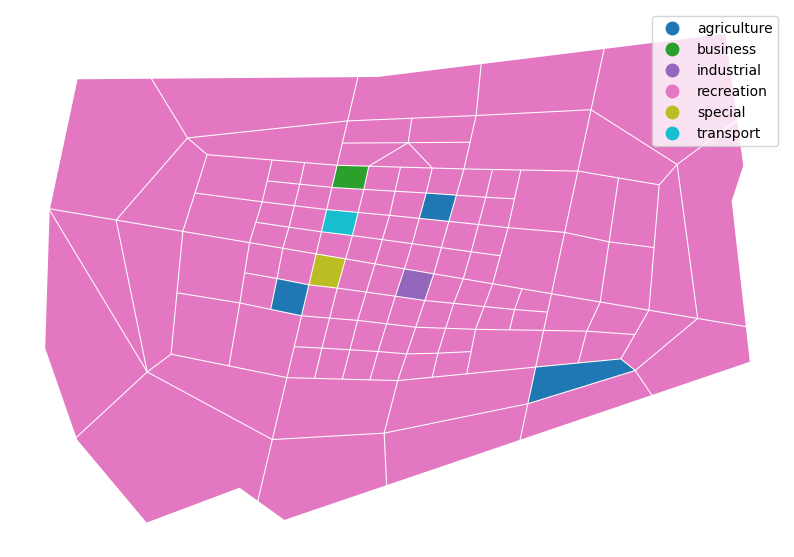

In [6]:
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

## Services optimizer

We have to find optimal services composition for this land use set.

In [7]:
import networkx as nx
from blocksnet import AccessibilityProcessor
from shapely import length, LineString, Point

SPEED = 10 * 1000 / 60

graph = luo.adjacency_graph.copy()
graph.graph['crs'] = luo.blocks.crs.to_epsg()
for node, data in graph.nodes(data=True):
  point = luo.blocks.loc[node,'geometry'].representative_point()
  data['geometry'] = point
  data['x'] = point.x
  data['y'] = point.y
for u, v, data in graph.edges(data=True):
  point_u = graph.nodes[u]['geometry']
  point_v = graph.nodes[v]['geometry']
  line_string = LineString([point_u, point_v])
  data['time_min'] = length(line_string)/SPEED

ap = AccessibilityProcessor(luo.blocks)
acc_mx = ap.get_accessibility_matrix(graph)

In [8]:
from blocksnet import City

city = City(luo.to_gdf(best_X), acc_mx)

In [9]:
import pandas as pd
import numpy as np

import optuna
from optuna.samplers import TPESampler

from blocksnet.method import LandUse, Provision, BaseMethod
from blocksnet.method.annealing_optimizer import Variable, Indicator

from typing import Any, List

import random

In [10]:

# class OptunaOptimizer(BaseMethod):
#     def __init__(self, city_model,
#                 block_id_for_opt: int,
#                 blocks_lu: dict[int, LandUse],
#                 blocks_fsi: dict[int, float],
#                 blocks_gsi: dict[int, float],
#                 service_types: dict[str, float]
#                 ):
#         super().__init__(city_model=city_model)

#         self.first_X  = self._generate_initial_X(blocks_lu, service_types)

#         self.block_id_for_opt = block_id_for_opt
#         self.algorithm = TPESampler(constraints_func=self.tpe_constraints)
#         self.study = optuna.create_study(sampler=self.algorithm)
#         print("self.first_X ========== ", self.first_X)
#         df = self.to_bricks_df(self.first_X)
        
#         print("df ========== ", df)


#         self.indicators = self._generate_indicators(blocks_lu, blocks_fsi, blocks_gsi)
#         self.block_indicator = self.indicators[block_id_for_opt]

#         self.brick_areas = np.array(df[df.block_id == block_id_for_opt]["area"])
#         self.brick_capacities = np.array(df[df.block_id == block_id_for_opt]["capacity"])
#         self.bricks_is_intagrated = np.array(df[df.block_id == block_id_for_opt]["is_integrated"])

#         self.service_type = random.choice(self.first_X)

#         self.block_area_integrated = self.block_indicator.integrated_area
#         self.block_area_non_integrated = self.block_indicator.non_integrated_area
#         self.service_types = {st.name : 1/len(self.city.service_types) for st in self.city.service_types}

#         self.var_count = len(self.first_X)

#     def _check_constraints(self, X, indicators) -> bool:
#         """
#         Checks if the current solution satisfies all constraints.

#         Parameters
#         ----------
#         X : list[Variable]
#             List of variables representing the current solution.
#         indicators : dict[int, Indicator]
#             Dictionary mapping block IDs to their corresponding indicators.

#         Returns
#         -------
#         bool
#             True if all constraints are satisfied, False otherwise.
#         """
#         df = self.to_bricks_df(X)
#         df["integrated_area"] = df.apply(lambda s: s["area"] * s["count"] if s["is_integrated"] else 0, axis=1)
#         df["non_integrated_area"] = df.apply(lambda s: s["area"] * s["count"] if not s["is_integrated"] else 0, axis=1)

#         if any(df["count"] < 0):
#             return False

#         df = df.groupby("block_id").agg({"integrated_area": "sum", "non_integrated_area": "sum"})

#         for block_id in df.index:

#             indicator: Indicator = indicators[block_id]

#             integrated_area = indicator.integrated_area
#             if df.loc[block_id, "integrated_area"] > integrated_area:
#                 return False

#             if df.loc[block_id, "non_integrated_area"] > integrated_area:
#                 return False
#         return True

#     def _generate_initial_X(self, blocks_lu: dict[int, LandUse], service_types: dict[str, float]):
#         """
#         Generates an initial list of variables for the optimization.

#         Parameters
#         ----------
#         blocks_lu : dict[int, LandUse]
#             Dictionary mapping block IDs to their corresponding land uses.
#         service_types : dict[str, float]
#             Dictionary mapping service type names to their weights.

#         Returns
#         -------
#         list[Variable]
#             A list of variables representing the initial solution.
#         """
#         X = []
#         for block_id, land_use in blocks_lu.items():
#             block = self.city_model[block_id]
#             user_service_types = {self.city_model[st_name] for st_name in service_types.keys()}
#             lu_service_types = set(self.city_model.get_land_use_service_types(land_use))
#             for service_type in user_service_types & lu_service_types:
#                 for brick in service_type.bricks:
#                     x = Variable(block=block, service_type=service_type, brick=brick)
#                     X.append(x)
#         return X

#     def to_bricks_df(self, X: list[Variable]) -> pd.DataFrame:
#         """
#         Converts the list of variables into a DataFrame representing the bricks.

#         Parameters
#         ----------
#         X : list[Variable]
#             List of variables representing the current solution.

#         Returns
#         -------
#         pd.DataFrame
#             A DataFrame containing data about the bricks in the solution.
#         """
#         xs = [
#             {
#                 "block_id": x.block.id,
#                 "service_type": x.service_type.name,
#                 "is_integrated": x.brick.is_integrated,
#                 "area": x.brick.area,
#                 "capacity": x.brick.capacity,
#                 "count": x.value,
#             }
#             for x in X
#         ]
#         df = pd.DataFrame(list(xs))
#         return df[df["count"] != 0]

#     def _get_clear_df(self, blocks: list[int]) -> pd.DataFrame:
#         """
#         Constructs a DataFrame for provision assessment so the blocks being changed are treated as cleared.

#         Parameters
#         ----------
#         blocks : list[int]
#             List of changing blocks ids.
#         Returns
#         -------
#         pd.DataFrame
#             A DataFrame containing information related to blocks being changed for provision assessment.
#         """
#         gdf = self.city_model.get_blocks_gdf()
#         gdf = gdf[gdf.index.isin(blocks)]
#         df = gdf[["population"]].copy()
#         df["population"] = -df["population"]
#         df.sum()
#         for column in [column for column in gdf.columns if "capacity_" in column]:
#             st_name = column.removeprefix("capacity_")
#             df[st_name] = -gdf[column]
#         return df
    
#     def to_df(self, X: list[Variable], indicators: dict[int, Indicator]) -> pd.DataFrame:
#         """
#         Converts the list of variables and indicators into a DataFrame.

#         Parameters
#         ----------
#         X : list[Variable]
#             List of variables representing the current solution.
#         indicators : dict[int, Indicator]
#             Dictionary mapping block IDs to their corresponding indicators.

#         Returns
#         -------
#         pd.DataFrame
#             A DataFrame containing data about the blocks and their service capacities.
#         """
#         service_types = {x.service_type for x in X}
#         df = pd.DataFrame(
#             [
#                 {
#                     "block_id": x.block.id,
#                     "population": indicators[x.block.id].population,
#                     x.service_type.name: x.capacity,
#                 }
#                 for x in X
#             ]
#         )
#         return df.groupby("block_id").agg({"population": "min", **{st.name: "sum" for st in service_types}})

    
#     def _generate_indicators(self, blocks, fsis, gsis) -> dict[int, Indicator]:
#         """
#         Generates indicators for each block based on the provided data.

#         Parameters
#         ----------
#         blocks : dict[int, LandUse]
#             Dictionary mapping block IDs to their corresponding land uses.
#         fsis : dict[int, float]
#             Dictionary mapping block IDs to their Floor Space Index (FSI) values.
#         gsis : dict[int, float]
#             Dictionary mapping block IDs to their Ground Space Index (GSI) values.

#         Returns
#         -------
#         dict[int, Indicator]
#             A dictionary mapping block IDs to their corresponding indicators.
#         """
#         return {b_id: Indicator(self.city_model[b_id], blocks[b_id], fsis[b_id], gsis[b_id]) for b_id in blocks.keys()}


#     def to_list_variables(prev_x: list[Variable], x: pd.DataFrame):
#         x_v = prev_x
#         for i in range(len(x_v)):
#             x_v[i].value = x[str(i)].iloc[0]
#         return x_v
    

#     def calculate_provision(self,
#                             clear_df: pd.DataFrame, 
#                             prov: Provision, 
#                             x: list[Variable], 
#                             indicators: list[Indicator],
#                             service_type):
#         update_df = clear_df.add(self.to_df(x, indicators))
#         if update_df[service_type.name].sum() == 0:
#             return 0
#         gdf = prov.calculate(service_type, update_df, self_supply=True)
#         return prov.total(gdf)
    
#     def tpe_constraints(self, trial):
#         params = trial.params
#         n = self.var_count
#         x = []
#         for i in range(n):
#             x.append(params[f"x_{i}"])
#         x = np.array(x)
        
#         x_areas = x @ self.brick_areas

#         if x_areas[self.bricks_is_intagrated] > self.block_area_integrated:
#             return False
        
#         if x_areas[~self.bricks_is_intagrated] > self.block_area_integrated:
#             return False

#         return True
    
#     def recount_provision(self, x: list[Variable], provisions: dict):
#         for st in self.city_model.service_types:
#             provisions[st.name] = self.calculate_provision(x, st)
#         return
    
#     # def tpe_callback(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):

#     # def check_constraint(self, x):
#     #     # TODO: Дописать проверку ограничений - преобразовать вектор brick_area к обычному вектору
#     #     if x * vector_area_block < block_whole_area:
#     #         return True
#     #     else:
#             # return False

#     def calculate(
#             self,
#             max_iter: int = 1000,
#         ) -> tuple:

#             clear_df = self._get_clear_df(blocks_lu.keys())

#             prov = Provision(city_model=self.city_model, verbose=False)

#             provisions = {st: 0.0 for st in service_types.keys()}

#             def ListInt_to_Variables(solution_list: List[int]):
#                 j = 0
#                 newX = self.first_X
#                 for i, var in enumerate(newX):
#                     if var.block.id == self.block_id_for_opt:
#                         newX[i].value = solution_list[j]
#                         j += 1
#                     if j > len(solution_list):
#                         raise IndexError("amount of variables more than in self.first_X")
#                 return newX
                
#             def calculate_provision(X, service_type):
#                 update_df = clear_df.add(self.to_df(X, self.indicators))
#                 if update_df[service_type.name].sum() == 0:
#                     return 0
#                 gdf = prov.calculate(service_type, update_df, self_supply=True)
#                 return prov.total(gdf)
            
#             def objective(trial):
#                 n = self.var_count
#                 x = []
#                 for i in range(n):
#                     x.append(trial.suggest_int(f"x_{i}", 0, 2))
                
#                 # Integrated check
#                 c0 = 0
#                 for i, x_i in enumerate(x):
#                     if self.bricks_is_intagrated[i]:
#                         c0 = c0 + x_i*int(self.brick_areas.iloc[i])
#                 c0 = c0 - self.block_area_integrated

#                 # Not Integrated check
#                 c1 = 0
#                 for i, x_i in enumerate(x):
#                     if not self.bricks_is_intagrated[i]:
#                         c1 = c1 + x_i*int(self.brick_areas.iloc[i])
#                 c1 = c1 - self.block_area_integrated

#                 trial.set_user_attr("constraint", (c0, c1))

#                 provisions[st.name] = self.calculate_provision(ListInt_to_Variables(x), self.service_type)
                
#                 val = sum(provisions[st] * w for st, w in service_types.items())

#                 return val

#             result = self.study.optimize(func=self.objective, n_trials=2, show_progress_bar=True )


#             return result

In [11]:
from blocksnet.method.provision import Provision
from blocksnet.method.annealing_optimizer import Variable
from blocksnet.method.base_method import BaseMethod
import optuna
from optuna.samplers import TPESampler
import random


import numpy as np
import pandas as pd

class OptunaOptimizer:
    def __init__(self, city_model,
                block_id_for_opt: int,
                blocks_lu: dict[int, LandUse],
                blocks_fsi: dict[int, float],
                blocks_gsi: dict[int, float],
                service_types: dict[str, float]
                ):
        self.city_model = city_model
        self.first_X  = self._generate_initial_X(blocks_lu, service_types)
        self.blocks_lu = blocks_lu
        self.block_id_for_opt = random.choice(list(city_model._blocks.keys()))
        self.algorithm = TPESampler(constraints_func=self.tpe_constraints)
        self.study = optuna.create_study(sampler=self.algorithm)

        print("self.first_X ========== ", self.first_X)
        df = self.to_bricks_df(self.first_X)
        print("df ========== ", df)
        
        self.indicators = self._generate_indicators(blocks_lu, blocks_fsi, blocks_gsi)
        self.block_indicator = self.indicators[block_id_for_opt]

        print("self.block_id_for_opt = ", self.block_id_for_opt)
        print("df.block_id == self.block_id_for_opt", df.block_id == self.block_id_for_opt)

        self.brick_areas = np.array(df[df.block_id == self.block_id_for_opt]["area"])

        print("000000000000000000000000000000000 self.brick_areas =", self.brick_areas)

        self.brick_capacities = np.array(df[df.block_id == block_id_for_opt]["capacity"])
        self.bricks_is_intagrated = np.array(df[df.block_id == block_id_for_opt]["is_integrated"])
        
        print("000000000000000000000000000000000 self.bricks_is_intagrated =", self.bricks_is_intagrated)

        self.service_type = random.choice(self.first_X)

        self.block_area_integrated = self.block_indicator.integrated_area
        self.block_area_non_integrated = self.block_indicator.non_integrated_area
        self.service_types = service_types
        print("000000000000000000000000000000000 self.service_types =", self.service_types)


        self.var_count = len(self.first_X)
        self.bricks_count = len([i for i in self.first_X if i.block.id == self.block_id_for_opt])

    def _check_constraints(self, X, indicators) -> bool:
        """
        Checks if the current solution satisfies all constraints.

        Parameters
        ----------
        X : list[Variable]
            List of variables representing the current solution.
        indicators : dict[int, Indicator]
            Dictionary mapping block IDs to their corresponding indicators.

        Returns
        -------
        bool
            True if all constraints are satisfied, False otherwise.
        """
        df = self.to_bricks_df(X)
        df["integrated_area"] = df.apply(lambda s: s["area"] * s["count"] if s["is_integrated"] else 0, axis=1)
        df["non_integrated_area"] = df.apply(lambda s: s["area"] * s["count"] if not s["is_integrated"] else 0, axis=1)

        if any(df["count"] < 0):
            return False

        df = df.groupby("block_id").agg({"integrated_area": "sum", "non_integrated_area": "sum"})

        for block_id in df.index:

            indicator: Indicator = indicators[block_id]

            integrated_area = indicator.integrated_area
            if df.loc[block_id, "integrated_area"] > integrated_area:
                return False

            if df.loc[block_id, "non_integrated_area"] > integrated_area:
                return False
        return True

    def _generate_initial_X(self, blocks_lu: dict[int, LandUse], service_types: dict[str, float]) -> list[Variable]:
        """
        Generates an initial list of variables for the optimization.

        Parameters
        ----------
        blocks_lu : dict[int, LandUse]
            Dictionary mapping block IDs to their corresponding land uses.
        service_types : dict[str, float]
            Dictionary mapping service type names to their weights.

        Returns
        -------
        list[Variable]
            A list of variables representing the initial solution.
        """
        X = []
        for block_id, land_use in blocks_lu.items():
            block = self.city_model[block_id]
            user_service_types = {self.city_model[st_name] for st_name in service_types.keys()}
            lu_service_types = set(self.city_model.get_land_use_service_types(land_use))
            for service_type in user_service_types & lu_service_types:
                for brick in service_type.bricks:
                    x = Variable(block=block, service_type=service_type, brick=brick)
                    X.append(x)
        return X

    def to_bricks_df(self, X: list[Variable]) -> pd.DataFrame:
        """
        Converts the list of variables into a DataFrame representing the bricks.

        Parameters
        ----------
        X : list[Variable]
            List of variables representing the current solution.

        Returns
        -------
        pd.DataFrame
            A DataFrame containing data about the bricks in the solution.
        """
        print(X)
        xs = [
            {
                "block_id": x.block.id,
                "service_type": x.service_type.name,
                "is_integrated": x.brick.is_integrated,
                "area": x.brick.area,
                "capacity": x.brick.capacity,
                "count": x.value,
            }
            for x in X
        ]
        print(xs)
        df = pd.DataFrame(list(xs))
        # return df[df["count"] != 0]
        return df

    def _get_clear_df(self, blocks: list[int]) -> pd.DataFrame:
        """
        Constructs a DataFrame for provision assessment so the blocks being changed are treated as cleared.

        Parameters
        ----------
        blocks : list[int]
            List of changing blocks ids.
        Returns
        -------
        pd.DataFrame
            A DataFrame containing information related to blocks being changed for provision assessment.
        """
        gdf = self.city_model.get_blocks_gdf()
        gdf = gdf[gdf.index.isin(blocks)]
        df = gdf[["population"]].copy()
        df["population"] = -df["population"]
        df.sum()
        for column in [column for column in gdf.columns if "capacity_" in column]:
            st_name = column.removeprefix("capacity_")
            df[st_name] = -gdf[column]
        return df
    
    def to_df(self, X: list[Variable], indicators: dict[int, Indicator]) -> pd.DataFrame:
        """
        Converts the list of variables and indicators into a DataFrame.

        Parameters
        ----------
        X : list[Variable]
            List of variables representing the current solution.
        indicators : dict[int, Indicator]
            Dictionary mapping block IDs to their corresponding indicators.

        Returns
        -------
        pd.DataFrame
            A DataFrame containing data about the blocks and their service capacities.
        """
        service_types = {x.service_type for x in X}
        df = pd.DataFrame(
            [
                {
                    "block_id": x.block.id,
                    "population": indicators[x.block.id].population,
                    x.service_type.name: x.capacity,
                }
                for x in X
            ]
        )
        return df.groupby("block_id").agg({"population": "min", **{st.name: "sum" for st in service_types}})

    
    def _generate_indicators(self, blocks, fsis, gsis) -> dict[int, Indicator]:
        """
        Generates indicators for each block based on the provided data.

        Parameters
        ----------
        blocks : dict[int, LandUse]
            Dictionary mapping block IDs to their corresponding land uses.
        fsis : dict[int, float]
            Dictionary mapping block IDs to their Floor Space Index (FSI) values.
        gsis : dict[int, float]
            Dictionary mapping block IDs to their Ground Space Index (GSI) values.

        Returns
        -------
        dict[int, Indicator]
            A dictionary mapping block IDs to their corresponding indicators.
        """
        return {b_id: Indicator(self.city_model[b_id], blocks[b_id], fsis[b_id], gsis[b_id]) for b_id in blocks.keys()}


    # def to_list_variables(prev_x: list[Variable], x: pd.DataFrame):
    #     x_v = prev_x
    #     for i in range(len(x_v)):
    #         x_v[i].value = x[str(i)].iloc[0]
    #     return x_v
    

    def calculate_provision(self,
                            clear_df: pd.DataFrame, 
                            prov: Provision, 
                            x: list[Variable], 
                            indicators: list[Indicator],
                            service_type):
        update_df = clear_df.add(self.to_df(x, indicators))
        if update_df[service_type.name].sum() == 0:
            return 0
        gdf = prov.calculate(service_type, update_df, self_supply=True)
        return prov.total(gdf)
    
    def tpe_constraints(self, trial):
        params = trial.params
        n = self.bricks_count
        x = []
        for i in range(n):
            x.append(params[f"x_{i}"])
        x = np.array(x)

        x_areas = x @ self.brick_areas

        print("----tpe_constraints-------------------------------------", x_areas)

        if x_areas[self.bricks_is_intagrated] > self.block_area_integrated:
            return False
        
        if x_areas[~self.bricks_is_intagrated] > self.block_area_integrated:
            return False
        return True
    

    def calculate(
            self,
            max_iter: int = 1000,
        ) -> tuple:

            clear_df = self._get_clear_df(self.blocks_lu.keys())

            prov = Provision(city_model=self.city_model, verbose=False)

            provisions = {st: 0.0 for st in self.service_types.keys()}

            def ListInt_to_Variables(solution_list: List[int]):
                j = 0
                newX = self.first_X
                for i, var in enumerate(newX):
                    if var.block.id == self.block_id_for_opt:
                        newX[i].value = solution_list[j]
                        j += 1
                    if j > len(solution_list):
                        raise IndexError("amount of variables more than in self.first_X")
                return newX
                
            # def calculate_provision(X, service_type):
            #     update_df = clear_df.add(self.to_df(X, self.indicators))
            #     if update_df[service_type.name].sum() == 0:
            #         return 0
            #     gdf = prov.calculate(service_type, update_df, self_supply=True)
            #     return prov.total(gdf)
                # def calculate_provision(self,
                #             clear_df: pd.DataFrame, 
                #             prov: Provision, 
                #             x: list[Variable], 
                #             indicators: list[Indicator],
                #             service_type):

            def recount_provision(x: list[Variable], provisions: dict):
                for st in self.city_model.service_types:
                    provisions[st.name] = self.calculate_provision(clear_df, prov, x, self.indicators , st)
                return provisions
            
            def objective(trial):
                n = self.bricks_count
                x = []
                for i in range(n):
                    x.append(trial.suggest_int(f"x_{i}", 0, 2))
                
                # Integrated check
                c0 = 0
                print("zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz")
                print(len(x))
                print(len(self.bricks_is_intagrated))
                print("zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz")
               
                for i, x_i in enumerate(x):
                    if i < len(self.bricks_is_intagrated) and self.bricks_is_intagrated[i]:
                        c0 = c0 + x_i*int(self.brick_areas[i])
                c0 = c0 - self.block_area_integrated


                # Not Integrated check
                c1 = 0
                for i, x_i in enumerate(x):
                    if i < len(self.bricks_is_intagrated) and not self.bricks_is_intagrated[i]:
                        c1 = c1 + x_i*int(self.brick_areas[i])
                c1 = c1 - self.block_area_integrated

                trial.set_user_attr("constraint", (c0, c1))

                provisions_local  = recount_provision(ListInt_to_Variables(x), provisions)

                print("------------- provisions_local", provisions_local)
                val = sum(provisions_local[st] * w for st, w in self.service_types.items())

                return val

            result = self.study.optimize(func=objective, n_trials=100, show_progress_bar=True )


            return result
    

In [12]:
from blocksnet.method.annealing_optimizer import LU_FSIS, LU_GSIS

blocks_lu = {block.id : best_X[block.id] for block in city.blocks}
blocks_fsi = {b_id : LU_FSIS[lu][0] for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_GSIS[lu][0] for b_id, lu in blocks_lu.items()}
service_types = {service_type.name : 1/len(city.service_types) for service_type in city.service_types}

values = []

def on_iteration(i, X, indicators, value):
    values.append(value)

In [ ]:
opo = OptunaOptimizer(city_model=city, block_id_for_opt=0, blocks_lu=blocks_lu, blocks_fsi=blocks_fsi, blocks_gsi=blocks_gsi, service_types=service_types)

opo.calculate()

In [14]:


ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration, verbose=True)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.95, max_iter=100_000)

plt.plot(values)

NameError: name 'AnnealingOptimizer' is not defined

In [19]:
provisions

{'school': nan,
 'kindergarten': nan,
 'hospital': 0.0,
 'polyclinic': nan,
 'pitch': nan,
 'swimming_pool': nan,
 'stadium': 0.0,
 'theatre': nan,
 'museum': nan,
 'cinema': nan,
 'mall': 0.0,
 'convenience': nan,
 'supermarket': nan,
 'cemetery': 0.0,
 'religion': nan,
 'market': nan,
 'bowling_alley': nan,
 'university': nan,
 'playground': 0.0,
 'pharmacy': nan,
 'fuel': nan,
 'beach': nan,
 'train_building': nan,
 'bank': 0.0,
 'lawyer': nan,
 'cafe': nan,
 'subway_entrance': nan,
 'multifunctional_center': nan,
 'hairdresser': 0.0,
 'restaurant': nan,
 'bar': nan,
 'park': 0.0,
 'government': nan,
 'recruitment': nan,
 'hotel': 0.0,
 'zoo': nan,
 'circus': nan,
 'post': nan,
 'police': nan,
 'dog_park': nan,
 'hostel': nan,
 'bakery': 0.0,
 'parking': 0.0,
 'guest_house': nan,
 'reserve': 0.0,
 'sanatorium': nan,
 'embankment': nan,
 'machine-building_plant': 0.0,
 'brewery': nan,
 'woodworking_plant': 0.0,
 'oil_refinery': 0.0,
 'plant_of_building_materials': nan,
 'wastewater_p

This set of service units if the first approximation of possible composition.

In [26]:
ao.to_bricks_df(X)

,block_id,service_type,is_integrated,area,capacity,count


In [21]:
X[0].id

AttributeError: 'Variable' object has no attribute 'id'